In [8]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

In [2]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    shape_num = len(xc)//shape_size
    xc = np.reshape(xc, (shape_num, shape_size))
    yc = np.reshape(yc, (shape_num, shape_size))
    
    for j in range(shape_num):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    peak = 0
    p_index = 0
    p_pos = [(0,0),(0,0)]
    for j in range(1, 200):
        if SP[i][j] < SP[i][p_index]:
            p_index = j
        if SP[i][j - 1] >= 0.6 >=SP[i][j]:
            peak += 1
            p_pos = [((j-1)/2+200,SP[i][j - 1]), (j/2+200, SP[i][j])]
    if peak == 1:
        distribution.append([1,p_index/2+200])
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	21
Batch 3 has 	18
Batch 4 has 	51
Batch 5 has 	15
Batch 6 has 	42
Batch 7 has 	42
Batch 8 has 	120
Batch 9 has 	15
Batch 10 has 	42
Batch 11 has 	42
Batch 12 has 	120
Batch 13 has 	39
Batch 14 has 	111
Batch 15 has 	111
Batch 16 has 	318
Batch 17 has 	15
Batch 18 has 	42
Batch 19 has 	42
Batch 20 has 	120
Batch 21 has 	39
Batch 22 has 	111
Batch 23 has 	111
Batch 24 has 	106
Batch 25 has 	39
Batch 26 has 	111
Batch 27 has 	111
Batch 28 has 	318
Batch 29 has 	105
Batch 30 has 	300
Batch 31 has 	300
Batch 32 has 	861
Batch 33 has 	15
Batch 34 has 	38
Batch 35 has 	42
Batch 36 has 	118
Batch 37 has 	39
Batch 38 has 	105
Batch 39 has 	105
Batch 40 has 	310
Batch 41 has 	37
Batch 42 has 	106
Batch 43 has 	105
Batch 44 has 	318
Batch 45 has 	101
Batch 46 has 	250
Batch 47 has 	298
Batch 48 has 	836
Batch 49 has 	36
Batch 50 has 	101
Batch 51 has 	105
Batch 52 has 	316
Batch 53 has 	105
Batch 54 has 	300
Batch 55 has 	301
Batch 56 has 	842
Batch 57 has 	103
Batch 58 has 	294
Bat

In [9]:
distribution

[[1, 282.0],
 [1, 226.0],
 [1, 294.5],
 [1, 282.0],
 [1, 274.0],
 [1, 226.0],
 [1, 275.0],
 [1, 293.5],
 [1, 273.5],
 [1, 299.0],
 [1, 273.0],
 [1, 299.0],
 [1, 293.0],
 [1, 282.5],
 [1, 273.0],
 [1, 265.5],
 [1, 276.0],
 [1, 299.5],
 [1, 270.5],
 [1, 231.5],
 [1, 269.5],
 [1, 298.0],
 [1, 278.5],
 [1, 269.0],
 [1, 271.0],
 [1, 284.5],
 [1, 299.5],
 [1, 288.0],
 [1, 269.5],
 [1, 239.0],
 [1, 270.0],
 [1, 289.0],
 [1, 293.0],
 [1, 269.0],
 [1, 294.5],
 [1, 285.5],
 [1, 270.5],
 [1, 290.0],
 [1, 281.5],
 [1, 294.5],
 [1, 289.5],
 [1, 280.0],
 [1, 270.5],
 [1, 284.0],
 [1, 271.0],
 [1, 237.0],
 [1, 269.0],
 [1, 278.0],
 [1, 268.5],
 [1, 269.5],
 [1, 299.5],
 [1, 280.0],
 [1, 286.5],
 [1, 268.0],
 [1, 299.5],
 [1, 267.0],
 [1, 297.0],
 [1, 291.0],
 [1, 268.0],
 [1, 299.5],
 [1, 288.0],
 [1, 279.5],
 [1, 296.5],
 [1, 287.0],
 [1, 291.0],
 [1, 286.0],
 [1, 276.5],
 [1, 267.5],
 [1, 299.5],
 [1, 274.5],
 [1, 290.5],
 [1, 297.0],
 [1, 269.0],
 [1, 230.0],
 [1, 289.5],
 [1, 268.0],
 [1, 289.0],

In [10]:
distribution = np.array(distribution)

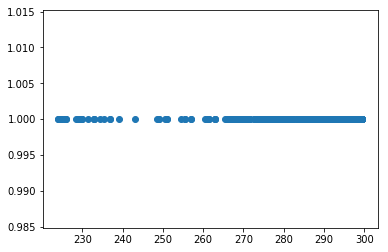

In [11]:
plt.scatter(distribution[:,1],distribution[:,0])

In [3]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 372 samples, validate on 93 samples
Epoch 1/1000
 - 1s - loss: 0.0933 - acc: 0.1882 - val_loss: 0.0568 - val_acc: 0.1613
Epoch 2/1000
 - 0s - loss: 0.0202 - acc: 0.1989 - val_loss: 0.0102 - val_acc: 0.3226
Epoch 3/1000
 - 0s - loss: 0.0065 - acc: 0.2043 - val_loss: 0.0045 - val_acc: 0.1828
Epoch 4/1000
 - 0s - loss: 0.0040 - acc: 0.3790 - val_loss: 0.0036 - val_acc: 0.1720
Epoch 5/1000
 - 0s - loss: 0.0035 - acc: 0.2231 - val_loss: 0.0035 - val_acc: 0.2903
Epoch 6/1000
 - 0s - loss: 0.0033 - acc: 0.4032 - val_loss: 0.0035 - val_acc: 0.1613
Epoch 7/1000
 - 0s - loss: 0.0033 - acc: 0.3011 - val_loss: 0.0034 - val_acc: 0.3333
Epoch 8/1000
 - 0s - loss: 0.0032 - acc: 0.4140 - val_loss: 0.0034 - val_acc: 0.3333
Epoch 9/1000
 - 0s - loss: 0.0032 - acc: 0.3817 - val_loss: 0.0034 - val_acc: 0.3333
Epoch 10/1000
 - 0s - loss: 0.0031 - acc: 0.4140 - val_loss: 0.0033 - 

Epoch 89/1000
 - 0s - loss: 0.0021 - acc: 0.3952 - val_loss: 0.0030 - val_acc: 0.2366
Epoch 90/1000
 - 0s - loss: 0.0022 - acc: 0.3683 - val_loss: 0.0029 - val_acc: 0.3763
Epoch 91/1000
 - 0s - loss: 0.0023 - acc: 0.3683 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 92/1000
 - 0s - loss: 0.0022 - acc: 0.4220 - val_loss: 0.0029 - val_acc: 0.3118
Epoch 93/1000
 - 0s - loss: 0.0021 - acc: 0.3871 - val_loss: 0.0029 - val_acc: 0.3548
Epoch 94/1000
 - 0s - loss: 0.0022 - acc: 0.4140 - val_loss: 0.0029 - val_acc: 0.2688
Epoch 95/1000
 - 0s - loss: 0.0023 - acc: 0.3387 - val_loss: 0.0029 - val_acc: 0.3548
Epoch 96/1000
 - 0s - loss: 0.0022 - acc: 0.3656 - val_loss: 0.0029 - val_acc: 0.3011
Epoch 97/1000
 - 0s - loss: 0.0022 - acc: 0.3763 - val_loss: 0.0028 - val_acc: 0.2366
Epoch 98/1000
 - 0s - loss: 0.0021 - acc: 0.4032 - val_loss: 0.0028 - val_acc: 0.3441
Epoch 99/1000
 - 0s - loss: 0.0021 - acc: 0.4140 - val_loss: 0.0031 - val_acc: 0.3118
Epoch 100/1000
 - 0s - loss: 0.0021 - acc: 0.3737 - va

Epoch 184/1000
 - 0s - loss: 0.0019 - acc: 0.3683 - val_loss: 0.0032 - val_acc: 0.3548
Epoch 185/1000
 - 0s - loss: 0.0019 - acc: 0.3790 - val_loss: 0.0029 - val_acc: 0.2473
Epoch 186/1000
 - 0s - loss: 0.0018 - acc: 0.3871 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 187/1000
 - 0s - loss: 0.0019 - acc: 0.3817 - val_loss: 0.0031 - val_acc: 0.3548
Epoch 188/1000
 - 0s - loss: 0.0018 - acc: 0.4167 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 189/1000
 - 0s - loss: 0.0018 - acc: 0.3629 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 190/1000
 - 0s - loss: 0.0019 - acc: 0.3602 - val_loss: 0.0029 - val_acc: 0.2903
Epoch 191/1000
 - 0s - loss: 0.0019 - acc: 0.3790 - val_loss: 0.0029 - val_acc: 0.3656
Epoch 192/1000
 - 0s - loss: 0.0019 - acc: 0.3790 - val_loss: 0.0029 - val_acc: 0.3011
Epoch 193/1000
 - 0s - loss: 0.0018 - acc: 0.4194 - val_loss: 0.0029 - val_acc: 0.3226
Epoch 194/1000
 - 0s - loss: 0.0018 - acc: 0.3763 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 195/1000
 - 0s - loss: 0.0018 - acc: 

 - 0s - loss: 0.0015 - acc: 0.3978 - val_loss: 0.0029 - val_acc: 0.3226
Epoch 279/1000
 - 0s - loss: 0.0017 - acc: 0.4140 - val_loss: 0.0032 - val_acc: 0.3118
Epoch 280/1000
 - 0s - loss: 0.0017 - acc: 0.3575 - val_loss: 0.0028 - val_acc: 0.3871
Epoch 281/1000
 - 0s - loss: 0.0015 - acc: 0.4328 - val_loss: 0.0029 - val_acc: 0.3548
Epoch 282/1000
 - 0s - loss: 0.0015 - acc: 0.4220 - val_loss: 0.0028 - val_acc: 0.3548
Epoch 283/1000
 - 0s - loss: 0.0015 - acc: 0.4032 - val_loss: 0.0029 - val_acc: 0.3763
Epoch 284/1000
 - 0s - loss: 0.0015 - acc: 0.4059 - val_loss: 0.0028 - val_acc: 0.3548
Epoch 285/1000
 - 0s - loss: 0.0015 - acc: 0.4086 - val_loss: 0.0028 - val_acc: 0.3763
Epoch 286/1000
 - 0s - loss: 0.0016 - acc: 0.4032 - val_loss: 0.0027 - val_acc: 0.3656
Epoch 287/1000
 - 0s - loss: 0.0015 - acc: 0.3925 - val_loss: 0.0030 - val_acc: 0.3978
Epoch 288/1000
 - 0s - loss: 0.0015 - acc: 0.4435 - val_loss: 0.0029 - val_acc: 0.3548
Epoch 289/1000
 - 0s - loss: 0.0015 - acc: 0.4032 - val_lo

Epoch 373/1000
 - 0s - loss: 0.0012 - acc: 0.4597 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 374/1000
 - 0s - loss: 0.0012 - acc: 0.4435 - val_loss: 0.0031 - val_acc: 0.3118
Epoch 375/1000
 - 0s - loss: 0.0014 - acc: 0.4194 - val_loss: 0.0031 - val_acc: 0.3763
Epoch 376/1000
 - 0s - loss: 0.0012 - acc: 0.4462 - val_loss: 0.0029 - val_acc: 0.3333
Epoch 377/1000
 - 0s - loss: 0.0012 - acc: 0.4624 - val_loss: 0.0027 - val_acc: 0.3548
Epoch 378/1000
 - 0s - loss: 0.0012 - acc: 0.4140 - val_loss: 0.0031 - val_acc: 0.3763
Epoch 379/1000
 - 0s - loss: 0.0012 - acc: 0.4435 - val_loss: 0.0029 - val_acc: 0.3333
Epoch 380/1000
 - 0s - loss: 0.0011 - acc: 0.4301 - val_loss: 0.0032 - val_acc: 0.3548
Epoch 381/1000
 - 0s - loss: 0.0013 - acc: 0.4409 - val_loss: 0.0030 - val_acc: 0.4086
Epoch 382/1000
 - 0s - loss: 0.0012 - acc: 0.4677 - val_loss: 0.0030 - val_acc: 0.3441
Epoch 383/1000
 - 0s - loss: 0.0012 - acc: 0.4570 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 384/1000
 - 0s - loss: 0.0012 - acc: 

Epoch 467/1000
 - 0s - loss: 0.0010 - acc: 0.4731 - val_loss: 0.0028 - val_acc: 0.2796
Epoch 468/1000
 - 0s - loss: 0.0011 - acc: 0.4301 - val_loss: 0.0029 - val_acc: 0.3978
Epoch 469/1000
 - 0s - loss: 0.0011 - acc: 0.4839 - val_loss: 0.0030 - val_acc: 0.3118
Epoch 470/1000
 - 0s - loss: 9.4825e-04 - acc: 0.4435 - val_loss: 0.0032 - val_acc: 0.3763
Epoch 471/1000
 - 0s - loss: 9.5258e-04 - acc: 0.4892 - val_loss: 0.0029 - val_acc: 0.3226
Epoch 472/1000
 - 0s - loss: 9.2719e-04 - acc: 0.4382 - val_loss: 0.0030 - val_acc: 0.3548
Epoch 473/1000
 - 0s - loss: 9.0629e-04 - acc: 0.4866 - val_loss: 0.0030 - val_acc: 0.3548
Epoch 474/1000
 - 0s - loss: 9.3212e-04 - acc: 0.4785 - val_loss: 0.0030 - val_acc: 0.2796
Epoch 475/1000
 - 0s - loss: 8.9799e-04 - acc: 0.4677 - val_loss: 0.0029 - val_acc: 0.3333
Epoch 476/1000
 - 0s - loss: 9.2620e-04 - acc: 0.4435 - val_loss: 0.0030 - val_acc: 0.3763
Epoch 477/1000
 - 0s - loss: 9.5158e-04 - acc: 0.4839 - val_loss: 0.0030 - val_acc: 0.3011
Epoch 478/1

Epoch 558/1000
 - 0s - loss: 8.0517e-04 - acc: 0.4731 - val_loss: 0.0030 - val_acc: 0.3441
Epoch 559/1000
 - 0s - loss: 7.9639e-04 - acc: 0.5108 - val_loss: 0.0030 - val_acc: 0.3011
Epoch 560/1000
 - 0s - loss: 8.6136e-04 - acc: 0.4839 - val_loss: 0.0028 - val_acc: 0.3656
Epoch 561/1000
 - 0s - loss: 7.5098e-04 - acc: 0.5027 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 562/1000
 - 0s - loss: 7.3913e-04 - acc: 0.5269 - val_loss: 0.0028 - val_acc: 0.3226
Epoch 563/1000
 - 0s - loss: 8.1332e-04 - acc: 0.5000 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 564/1000
 - 0s - loss: 7.7587e-04 - acc: 0.4866 - val_loss: 0.0030 - val_acc: 0.3333
Epoch 565/1000
 - 0s - loss: 8.6100e-04 - acc: 0.4543 - val_loss: 0.0028 - val_acc: 0.3548
Epoch 566/1000
 - 0s - loss: 7.8980e-04 - acc: 0.4946 - val_loss: 0.0029 - val_acc: 0.3333
Epoch 567/1000
 - 0s - loss: 7.6589e-04 - acc: 0.4973 - val_loss: 0.0030 - val_acc: 0.3441
Epoch 568/1000
 - 0s - loss: 7.6494e-04 - acc: 0.5188 - val_loss: 0.0028 - val_acc: 0.3333

 - 0s - loss: 7.4123e-04 - acc: 0.4704 - val_loss: 0.0031 - val_acc: 0.3763
Epoch 649/1000
 - 0s - loss: 8.2725e-04 - acc: 0.5323 - val_loss: 0.0030 - val_acc: 0.3226
Epoch 650/1000
 - 0s - loss: 7.8469e-04 - acc: 0.4409 - val_loss: 0.0031 - val_acc: 0.3763
Epoch 651/1000
 - 0s - loss: 9.1513e-04 - acc: 0.4516 - val_loss: 0.0032 - val_acc: 0.3333
Epoch 652/1000
 - 0s - loss: 8.6677e-04 - acc: 0.4812 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 653/1000
 - 0s - loss: 8.0169e-04 - acc: 0.4946 - val_loss: 0.0030 - val_acc: 0.2903
Epoch 654/1000
 - 0s - loss: 7.1166e-04 - acc: 0.5000 - val_loss: 0.0030 - val_acc: 0.3441
Epoch 655/1000
 - 0s - loss: 6.7149e-04 - acc: 0.5349 - val_loss: 0.0030 - val_acc: 0.2903
Epoch 656/1000
 - 0s - loss: 6.2960e-04 - acc: 0.5000 - val_loss: 0.0029 - val_acc: 0.3548
Epoch 657/1000
 - 0s - loss: 6.2703e-04 - acc: 0.5027 - val_loss: 0.0029 - val_acc: 0.2796
Epoch 658/1000
 - 0s - loss: 6.2418e-04 - acc: 0.4919 - val_loss: 0.0031 - val_acc: 0.3333
Epoch 659/1000

Epoch 739/1000
 - 0s - loss: 6.6009e-04 - acc: 0.5188 - val_loss: 0.0030 - val_acc: 0.3763
Epoch 740/1000
 - 0s - loss: 6.6959e-04 - acc: 0.5081 - val_loss: 0.0031 - val_acc: 0.3441
Epoch 741/1000
 - 0s - loss: 7.2080e-04 - acc: 0.4731 - val_loss: 0.0032 - val_acc: 0.3441
Epoch 742/1000
 - 0s - loss: 9.8739e-04 - acc: 0.4758 - val_loss: 0.0032 - val_acc: 0.3871
Epoch 743/1000
 - 0s - loss: 0.0010 - acc: 0.4677 - val_loss: 0.0032 - val_acc: 0.2796
Epoch 744/1000
 - 0s - loss: 7.3001e-04 - acc: 0.4758 - val_loss: 0.0030 - val_acc: 0.3333
Epoch 745/1000
 - 0s - loss: 6.0895e-04 - acc: 0.5161 - val_loss: 0.0031 - val_acc: 0.3548
Epoch 746/1000
 - 0s - loss: 6.0606e-04 - acc: 0.5565 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 747/1000
 - 0s - loss: 5.8035e-04 - acc: 0.5161 - val_loss: 0.0031 - val_acc: 0.3333
Epoch 748/1000
 - 0s - loss: 5.5315e-04 - acc: 0.5403 - val_loss: 0.0031 - val_acc: 0.2796
Epoch 749/1000
 - 0s - loss: 5.3708e-04 - acc: 0.5242 - val_loss: 0.0031 - val_acc: 0.3656
Epo

 - 0s - loss: 7.0657e-04 - acc: 0.5484 - val_loss: 0.0030 - val_acc: 0.3763
Epoch 830/1000
 - 0s - loss: 6.1644e-04 - acc: 0.4946 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 831/1000
 - 0s - loss: 5.5117e-04 - acc: 0.5134 - val_loss: 0.0030 - val_acc: 0.3441
Epoch 832/1000
 - 0s - loss: 5.8111e-04 - acc: 0.5134 - val_loss: 0.0031 - val_acc: 0.3656
Epoch 833/1000
 - 0s - loss: 5.5344e-04 - acc: 0.4892 - val_loss: 0.0030 - val_acc: 0.3871
Epoch 834/1000
 - 0s - loss: 5.5686e-04 - acc: 0.5081 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 835/1000
 - 0s - loss: 6.6493e-04 - acc: 0.5188 - val_loss: 0.0030 - val_acc: 0.3656
Epoch 836/1000
 - 0s - loss: 6.3897e-04 - acc: 0.4866 - val_loss: 0.0030 - val_acc: 0.3548
Epoch 837/1000
 - 0s - loss: 5.4086e-04 - acc: 0.5376 - val_loss: 0.0030 - val_acc: 0.3333
Epoch 838/1000
 - 0s - loss: 5.2785e-04 - acc: 0.5269 - val_loss: 0.0029 - val_acc: 0.3441
Epoch 839/1000
 - 0s - loss: 4.4341e-04 - acc: 0.5027 - val_loss: 0.0031 - val_acc: 0.3763
Epoch 840/1000

Epoch 920/1000
 - 0s - loss: 4.5313e-04 - acc: 0.5403 - val_loss: 0.0029 - val_acc: 0.3871
Epoch 921/1000
 - 0s - loss: 3.9776e-04 - acc: 0.5215 - val_loss: 0.0030 - val_acc: 0.3441
Epoch 922/1000
 - 0s - loss: 4.8726e-04 - acc: 0.5242 - val_loss: 0.0031 - val_acc: 0.4086
Epoch 923/1000
 - 0s - loss: 4.2953e-04 - acc: 0.5538 - val_loss: 0.0031 - val_acc: 0.4086
Epoch 924/1000
 - 0s - loss: 4.9958e-04 - acc: 0.4919 - val_loss: 0.0031 - val_acc: 0.3226
Epoch 925/1000
 - 0s - loss: 9.5932e-04 - acc: 0.4785 - val_loss: 0.0031 - val_acc: 0.3656
Epoch 926/1000
 - 0s - loss: 8.2951e-04 - acc: 0.4812 - val_loss: 0.0031 - val_acc: 0.3548
Epoch 927/1000
 - 0s - loss: 6.5701e-04 - acc: 0.5108 - val_loss: 0.0030 - val_acc: 0.3978
Epoch 928/1000
 - 0s - loss: 4.9216e-04 - acc: 0.5323 - val_loss: 0.0031 - val_acc: 0.3656
Epoch 929/1000
 - 0s - loss: 4.2342e-04 - acc: 0.5511 - val_loss: 0.0030 - val_acc: 0.3763
Epoch 930/1000
 - 0s - loss: 4.4401e-04 - acc: 0.5242 - val_loss: 0.0029 - val_acc: 0.3656

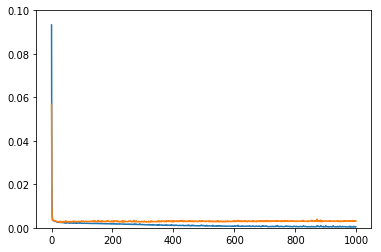

In [4]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.ylim(0,0.1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

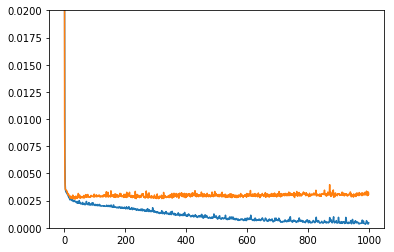

In [5]:
plt.ylim(0,0.02)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

93/93 [==============================] - 0s 69us/step
[0.0006851804771608302, 0.5779569879654916]
[0.002394191680415984, 0.34408603208039396]


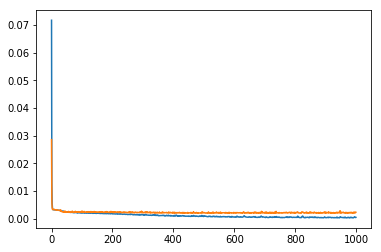

In [6]:
train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.4 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.400227   0.28566784 0.2280488  0.19561508 0.11617837 0.14598827]]

Predicted shape: [[0.40473604 0.29461318 0.1932919  0.19567707 0.19154394 0.13183373]]



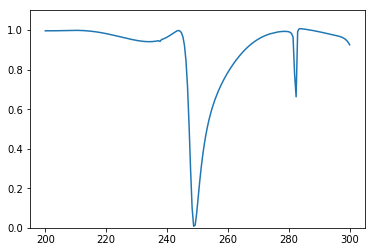

Test 1
True shape: [0.19753767 0.2        0.19753767 0.2        0.13169178 0.1       ]
Predicted shape: [[0.23626438 0.21508086 0.20605272 0.16123459 0.10725532 0.08627798]]

Predicted shape: [[0.20973861 0.20784438 0.20572516 0.17449397 0.12738755 0.13459697]]



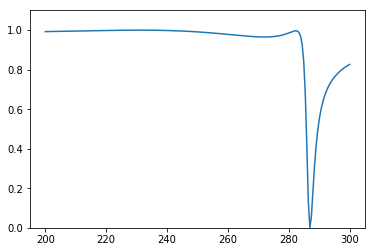

Test 2
True shape: [0.3 0.2 0.1 0.2 0.2 0.2]
Predicted shape: [[0.3070569  0.19769815 0.13322484 0.1841372  0.1742351  0.19976811]]

Predicted shape: [[0.23346433 0.19244787 0.15084448 0.15501279 0.20131947 0.21520402]]



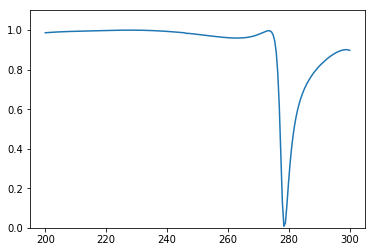

Test 3
True shape: [0.1        0.13169178 0.2        0.1        0.2        0.3       ]
Predicted shape: [[0.20886648 0.14533567 0.13761503 0.13507855 0.18622857 0.23758464]]

Predicted shape: [[0.17133749 0.13837865 0.14797023 0.15472645 0.18878277 0.26172236]]



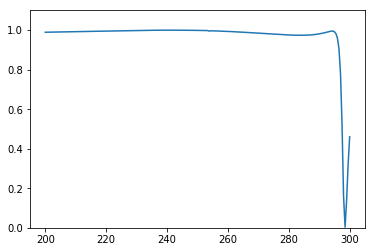

Test 4
True shape: [0.1        0.09876883 0.1        0.2        0.3        0.2963065 ]
Predicted shape: [[0.0953809  0.09481499 0.0983907  0.2018007  0.2937692  0.28205284]]

Predicted shape: [[0.09270081 0.09739414 0.10054398 0.19261843 0.30907297 0.30930248]]



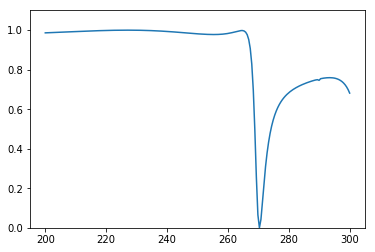

Test 5
True shape: [0.2 0.2 0.2 0.2 0.1 0.2]
Predicted shape: [[0.17423779 0.17076579 0.2127411  0.20698038 0.11440936 0.2106028 ]]

Predicted shape: [[0.20520535 0.19198576 0.20385313 0.17255208 0.12675068 0.22113404]]



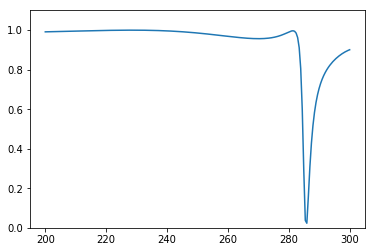

Test 6
True shape: [0.1        0.1        0.2        0.19753767 0.2        0.3       ]
Predicted shape: [[0.09930792 0.10243037 0.18565798 0.20728901 0.20473646 0.2833291 ]]

Predicted shape: [[0.08798099 0.10678509 0.17167535 0.2016198  0.20264703 0.30472633]]



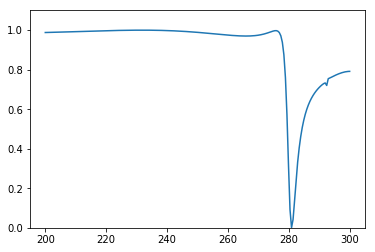

Test 7
True shape: [0.2 0.2 0.2 0.1 0.1 0.2]
Predicted shape: [[0.12955344 0.13052353 0.1234962  0.17979023 0.19034766 0.18041275]]

Predicted shape: [[0.15022594 0.14549169 0.14979953 0.15562296 0.16477561 0.20119537]]



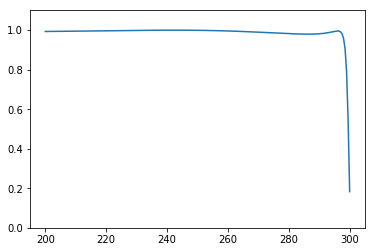

Test 8
True shape: [0.1       0.2       0.1       0.2       0.3       0.2963065]
Predicted shape: [[0.13778508 0.16837892 0.1243217  0.2276459  0.26382533 0.2448396 ]]

Predicted shape: [[0.11764267 0.18734613 0.11501193 0.19668797 0.2917898  0.31393772]]



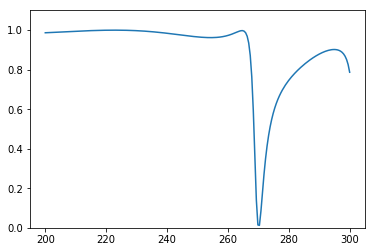

Test 9
True shape: [0.28531695 0.28887347 0.3        0.25051498 0.21968701 0.2       ]
Predicted shape: [[0.301767   0.2900548  0.2954352  0.20942137 0.18436031 0.27862382]]

Predicted shape: [[0.28930008 0.27942026 0.31202087 0.2424055  0.2270955  0.22410795]]



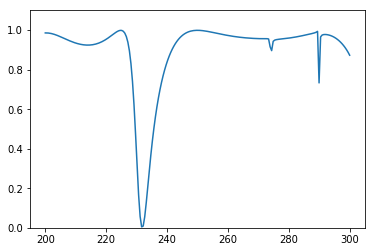

Test 10
True shape: [0.2        0.3        0.2        0.13169178 0.1        0.2       ]
Predicted shape: [[0.20976844 0.13440758 0.16779795 0.22350806 0.24002218 0.21307273]]

Predicted shape: [[0.19065768 0.28516424 0.23016304 0.14478439 0.10975548 0.15567918]]



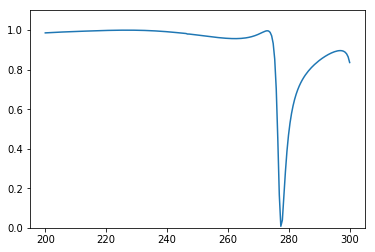

Test 11
True shape: [0.2963065 0.3       0.2       0.3       0.2370452 0.2      ]
Predicted shape: [[0.29386234 0.27003613 0.29226255 0.24951628 0.20470345 0.19754396]]

Predicted shape: [[0.31191635 0.28943846 0.21494696 0.26504987 0.2309268  0.20347124]]



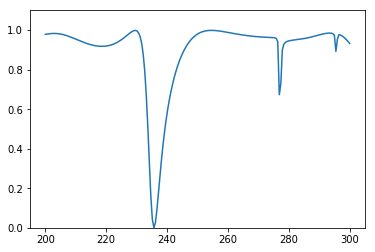

Test 12
True shape: [0.2        0.1        0.13169178 0.2        0.2        0.19753767]
Predicted shape: [[0.20333487 0.15845433 0.16017443 0.17128071 0.14355792 0.13562445]]

Predicted shape: [[0.17469198 0.12377989 0.15698409 0.15167034 0.20572063 0.21546939]]



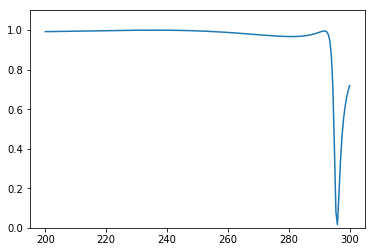

Test 13
True shape: [0.19753767 0.2        0.2        0.1        0.2        0.2       ]
Predicted shape: [[0.21595442 0.20996511 0.20231536 0.10476696 0.16695073 0.16846147]]

Predicted shape: [[0.20628378 0.22370175 0.18647084 0.1110144  0.18681936 0.20921138]]



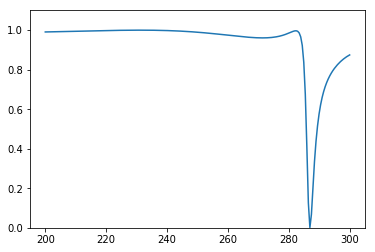

Test 14
True shape: [0.2        0.13169178 0.1        0.2        0.2370452  0.3       ]
Predicted shape: [[0.27005535 0.22490567 0.20382085 0.12731531 0.14507586 0.26314685]]

Predicted shape: [[0.26215804 0.20752627 0.17623338 0.13573265 0.16935244 0.25895146]]



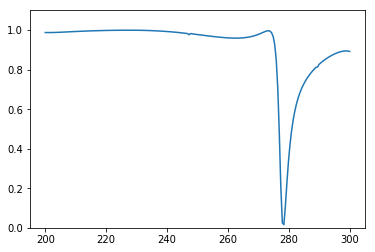

Test 15
True shape: [0.1        0.2        0.19753767 0.2        0.2        0.3       ]
Predicted shape: [[0.10720551 0.18821174 0.211701   0.20314464 0.20260979 0.29726526]]

Predicted shape: [[0.09926572 0.20275003 0.1968497  0.19563258 0.19075681 0.2947891 ]]



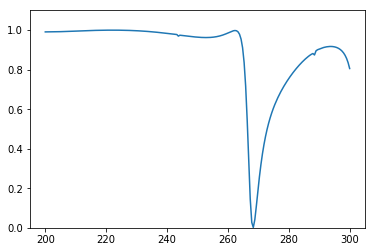

Test 16
True shape: [0.19753767 0.2        0.3        0.2        0.1        0.09876883]
Predicted shape: [[0.1981551  0.20627314 0.24670225 0.22201452 0.13434662 0.10231294]]

Predicted shape: [[0.20690739 0.22303265 0.26037633 0.18530667 0.11050464 0.11428913]]



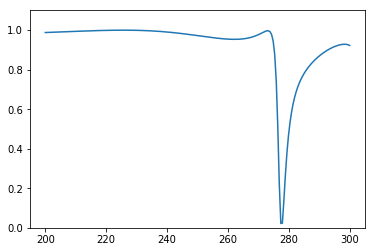

Test 17
True shape: [0.1        0.1        0.2        0.2        0.19753767 0.2       ]
Predicted shape: [[0.09035093 0.09177628 0.196264   0.1945884  0.20107514 0.1891982 ]]

Predicted shape: [[0.09696513 0.10481974 0.19896087 0.19119114 0.198847   0.19921805]]



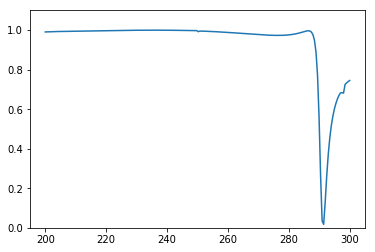

Test 18
True shape: [0.2        0.1        0.13169178 0.2        0.19753767 0.2       ]
Predicted shape: [[0.24308077 0.17445189 0.18056056 0.15071923 0.13072862 0.1169192 ]]

Predicted shape: [[0.20742962 0.14186555 0.16060221 0.15358484 0.18144508 0.18702842]]



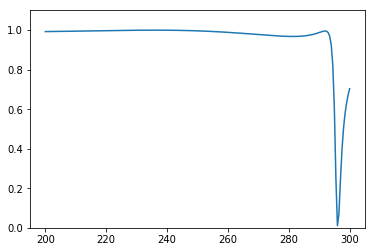

Test 19
True shape: [0.1902113  0.19258231 0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.12604332 0.13346297 0.12716374 0.19952562 0.18738699 0.14442535]]

Predicted shape: [[0.15422535 0.1435413  0.15321198 0.1640425  0.16931911 0.18252388]]



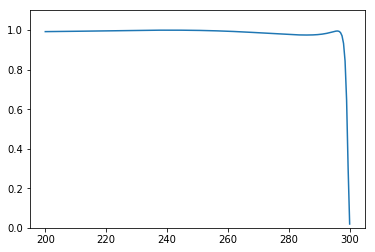

Test 20
True shape: [0.3        0.2        0.2        0.1        0.09629116 0.09510565]
Predicted shape: [[0.18755874 0.14817953 0.11264202 0.18688935 0.17735742 0.17116219]]

Predicted shape: [[0.26089278 0.16249546 0.16587368 0.15972087 0.15153483 0.17071651]]



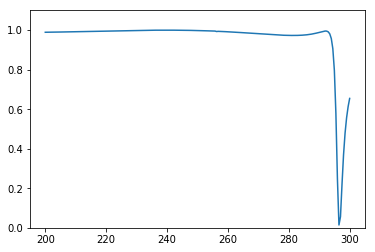

Test 21
True shape: [0.2        0.2        0.1        0.13169178 0.2        0.3       ]
Predicted shape: [[0.19172773 0.21279046 0.19010302 0.12256667 0.1465392  0.22080474]]

Predicted shape: [[0.20548907 0.17411944 0.14640939 0.12141547 0.19324316 0.27656278]]



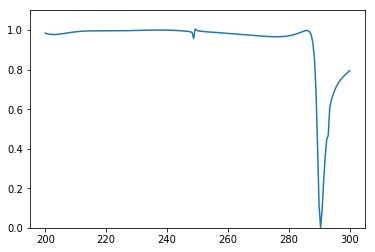

Test 22
True shape: [0.19753767 0.2        0.1        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.11002362 0.16228476 0.17146993 0.20359784 0.16417965 0.17506254]]

Predicted shape: [[0.15182123 0.2012434  0.15402734 0.19159016 0.17505364 0.14378078]]



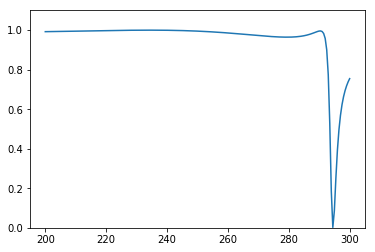

Test 23
True shape: [0.2        0.2        0.19753767 0.2        0.2        0.2       ]
Predicted shape: [[0.19729611 0.19555241 0.19601056 0.20318466 0.20264135 0.19470802]]

Predicted shape: [[0.20018819 0.20123303 0.19610941 0.19614187 0.20082746 0.20224638]]



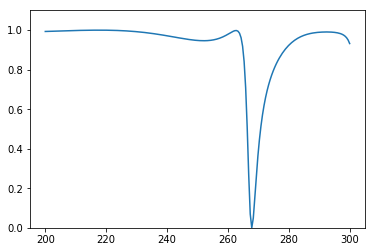

Test 24
True shape: [0.1902113  0.19258231 0.2        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.21249917 0.19956723 0.18713555 0.20009911 0.20373061 0.17532536]]

Predicted shape: [[0.19335791 0.20249856 0.18513107 0.18119806 0.19149509 0.2140304 ]]



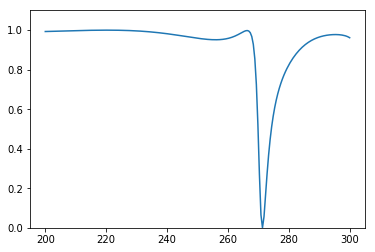

Test 25
True shape: [0.3        0.2        0.2        0.13169178 0.1        0.1       ]
Predicted shape: [[0.23828223 0.19762826 0.19537756 0.18527591 0.09157947 0.09168223]]

Predicted shape: [[0.24179736 0.19746274 0.19934353 0.17323369 0.095646   0.10810906]]



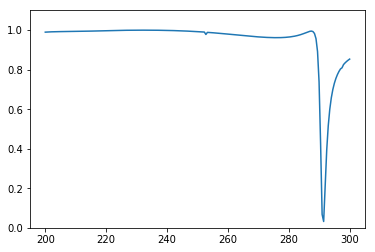

Test 26
True shape: [0.2        0.2        0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.21034375 0.2057721  0.23063716 0.2200956  0.12081669 0.19134273]]

Predicted shape: [[0.1831964  0.21509889 0.284751   0.20544371 0.12414406 0.16071141]]



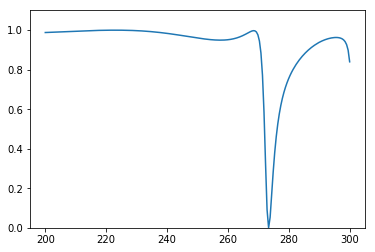

Test 27
True shape: [0.2 0.2 0.1 0.2 0.2 0.3]
Predicted shape: [[0.15623724 0.18914044 0.18726766 0.2499423  0.20522895 0.1022784 ]]

Predicted shape: [[0.23521596 0.18695644 0.14765555 0.15454334 0.21533515 0.27435023]]



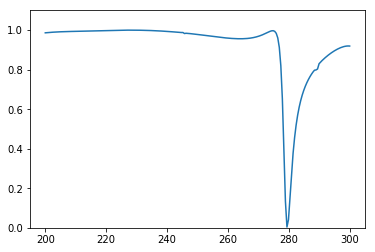

Test 28
True shape: [0.2       0.1       0.1       0.2       0.2370452 0.3      ]
Predicted shape: [[0.31310806 0.15622932 0.09769511 0.20800257 0.17619142 0.19614759]]

Predicted shape: [[0.21169713 0.16952944 0.12016153 0.15225971 0.22665244 0.3381881 ]]



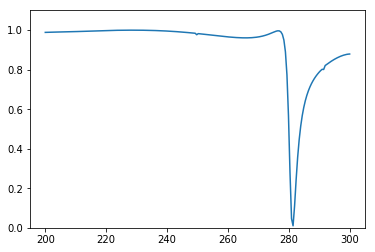

Test 29
True shape: [0.09876883 0.1        0.2        0.3        0.2        0.19753767]
Predicted shape: [[0.21330404 0.17914903 0.16293758 0.22621447 0.20530826 0.11530662]]

Predicted shape: [[0.10393775 0.10967353 0.1898644  0.2891907  0.20109376 0.2311994 ]]



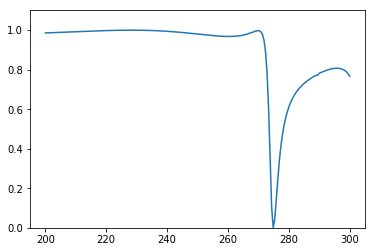

Test 30
True shape: [0.1 0.2 0.2 0.2 0.1 0.2]
Predicted shape: [[0.16769311 0.12656042 0.09815311 0.16229561 0.21262711 0.29331243]]

Predicted shape: [[0.1721093  0.16543508 0.158804   0.14930153 0.18088952 0.26848444]]



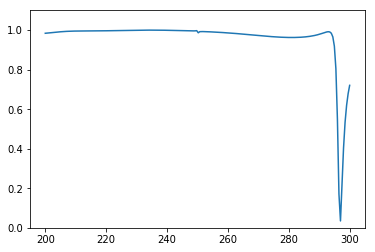

Test 31
True shape: [0.19753767 0.2        0.1        0.2        0.2        0.2       ]
Predicted shape: [[0.19659114 0.18117416 0.1421817  0.23095131 0.15809771 0.14008926]]

Predicted shape: [[0.20574823 0.18473798 0.1462703  0.17249528 0.15824923 0.17769407]]



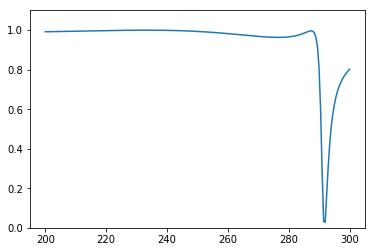

Test 32
True shape: [0.1        0.1        0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.09002042 0.09152669 0.19585443 0.19372293 0.2006116  0.18874076]]

Predicted shape: [[0.09704527 0.1051442  0.19919986 0.19152275 0.20042323 0.19916926]]



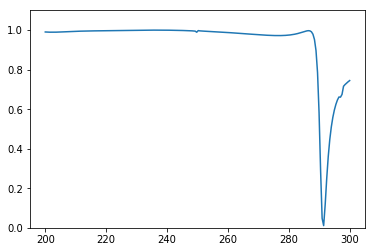

Test 33
True shape: [0.2        0.3        0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.09698296 0.13674381 0.15724942 0.24654207 0.2653411  0.17185067]]

Predicted shape: [[0.15980136 0.26495847 0.22518536 0.09351468 0.16088    0.20196544]]



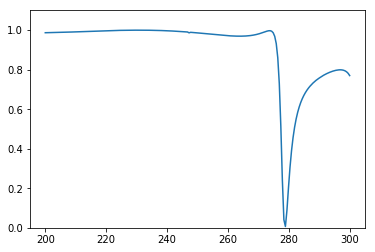

Test 34
True shape: [0.2        0.2        0.1        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.18843552 0.18253306 0.14462066 0.23393926 0.1598813  0.14030978]]

Predicted shape: [[0.19776744 0.17618462 0.15697664 0.16542351 0.15692544 0.18196732]]



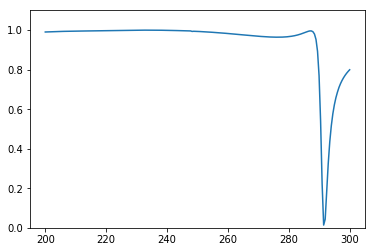

Test 35
True shape: [0.3        0.2963065  0.3        0.2370452  0.2        0.19753767]
Predicted shape: [[0.29917294 0.29776067 0.29738492 0.20815301 0.18856093 0.26796195]]

Predicted shape: [[0.30387327 0.30462897 0.2997009  0.23528734 0.20237505 0.22735196]]



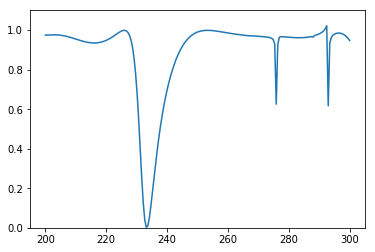

Test 36
True shape: [0.2 0.2 0.2 0.1 0.2 0.2]
Predicted shape: [[0.25540698 0.20621732 0.20177588 0.13541329 0.12413453 0.15961882]]

Predicted shape: [[0.21678698 0.22107926 0.18692976 0.11836272 0.182162   0.21025458]]



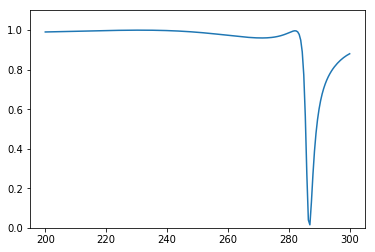

Test 37
True shape: [0.2        0.19753767 0.2        0.14600443 0.11723925 0.1       ]
Predicted shape: [[0.20177716 0.20918563 0.19431692 0.13532215 0.142796   0.07009262]]

Predicted shape: [[0.19643405 0.19442028 0.18134636 0.13708156 0.14866817 0.11535775]]



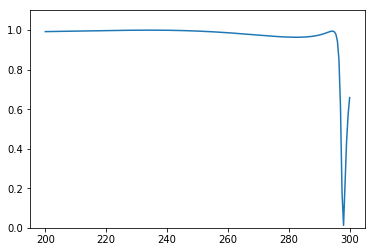

Test 38
True shape: [0.3        0.2        0.1        0.13169178 0.2        0.19753767]
Predicted shape: [[0.12142113 0.13734332 0.15933481 0.18277067 0.18143614 0.2087027 ]]

Predicted shape: [[0.2037782  0.16051045 0.14732668 0.16722804 0.18346865 0.22032395]]



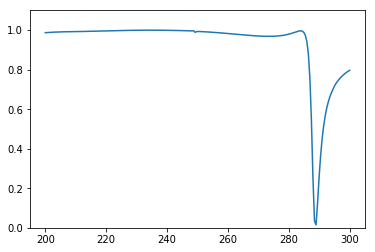

Test 39
True shape: [0.2 0.2 0.3 0.2 0.1 0.1]
Predicted shape: [[0.18801853 0.16764691 0.16112438 0.20318958 0.21879515 0.19919951]]

Predicted shape: [[0.22778106 0.18849793 0.25608113 0.20883778 0.11370456 0.1399822 ]]



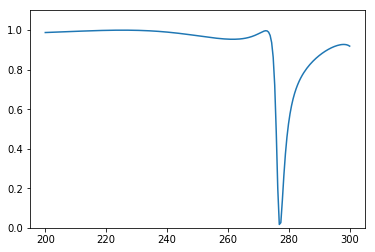

Test 40
True shape: [0.09876883 0.1        0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.09597623 0.10363284 0.19009027 0.21294594 0.19853398 0.19898838]]

Predicted shape: [[0.12164813 0.11777693 0.22321805 0.19516048 0.18357629 0.1963776 ]]



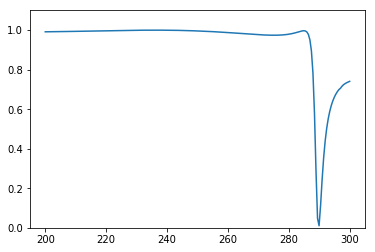

Test 41
True shape: [0.3       0.2963065 0.3       0.2370452 0.2       0.2      ]
Predicted shape: [[0.29984194 0.2983002  0.29808193 0.2076512  0.188163   0.27031326]]

Predicted shape: [[0.30298048 0.30624998 0.29751945 0.2341508  0.19948247 0.2319787 ]]



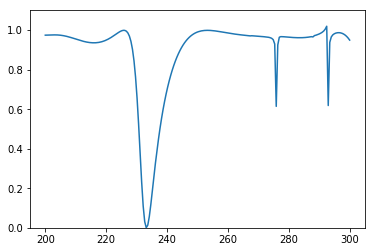

Test 42
True shape: [0.1902113  0.19258231 0.2        0.14600443 0.11723925 0.1       ]
Predicted shape: [[0.12298363 0.1311149  0.12666097 0.19735208 0.19066645 0.15760647]]

Predicted shape: [[0.15741009 0.15015814 0.15745571 0.16535896 0.17065966 0.18835495]]



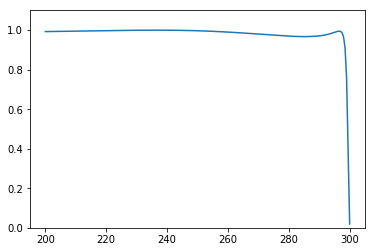

Test 43
True shape: [0.3        0.2        0.13169178 0.1        0.2        0.2       ]
Predicted shape: [[0.31473136 0.1734415  0.17232397 0.13761985 0.14658052 0.1219181 ]]

Predicted shape: [[0.2605464  0.20503348 0.15427262 0.10559046 0.21310039 0.2743653 ]]



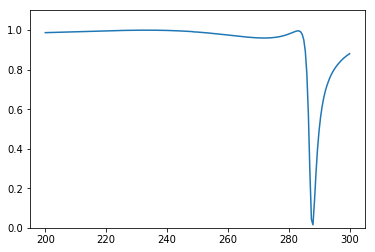

Test 44
True shape: [0.19753767 0.2        0.2        0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.19619548 0.19634196 0.19790769 0.20595926 0.2009937  0.19037312]]

Predicted shape: [[0.19650793 0.20748305 0.19497907 0.19394723 0.19578603 0.19326471]]



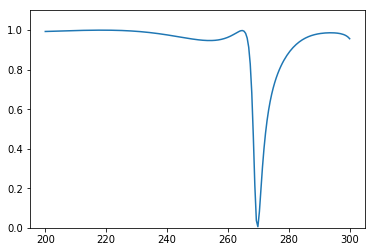

Test 45
True shape: [0.3        0.2        0.13169178 0.1        0.1        0.2       ]
Predicted shape: [[0.12355638 0.13104975 0.12671599 0.19450328 0.18901303 0.1556311 ]]

Predicted shape: [[0.14980787 0.14282319 0.14987862 0.1598466  0.1659462  0.18847187]]



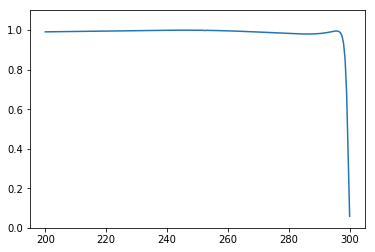

Test 46
True shape: [0.19753767 0.2        0.19258231 0.1902113  0.19258231 0.2       ]
Predicted shape: [[0.20329335 0.19556838 0.19095472 0.19829819 0.20297691 0.18169779]]

Predicted shape: [[0.19391301 0.20224652 0.18547809 0.1822162  0.19228819 0.21546468]]



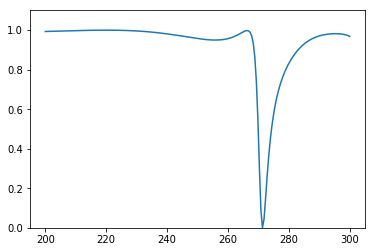

Test 47
True shape: [0.1        0.2        0.3        0.2        0.13169178 0.1       ]
Predicted shape: [[0.31730247 0.20351583 0.17068768 0.20932955 0.11486229 0.16829401]]

Predicted shape: [[0.19258046 0.20332295 0.23002043 0.19405326 0.12265459 0.13007323]]



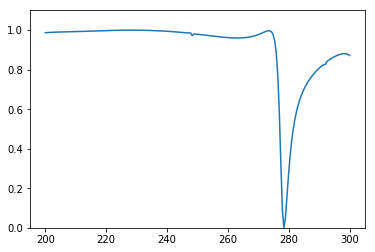

Test 48
True shape: [0.19753767 0.2        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.20854026 0.19657078 0.19313511 0.19904244 0.20013253 0.0987305 ]]

Predicted shape: [[0.2017689  0.20792273 0.20254129 0.1989814  0.19023363 0.09866502]]



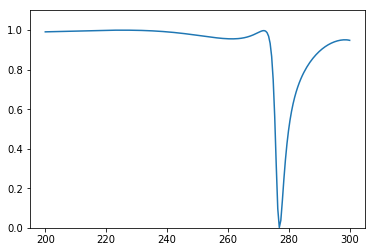

Test 49
True shape: [0.19753767 0.2        0.13169178 0.1        0.2        0.3       ]
Predicted shape: [[0.2340788  0.18066517 0.17727172 0.11446184 0.16907313 0.17909239]]

Predicted shape: [[0.2276999  0.20620799 0.16052902 0.10480705 0.20725615 0.28085965]]



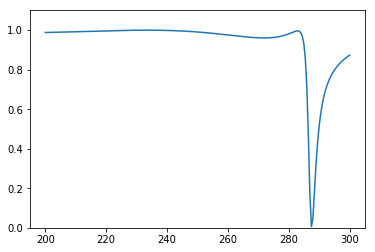

Test 50
True shape: [0.1 0.1 0.1 0.2 0.3 0.3]
Predicted shape: [[0.1008307  0.09694916 0.10155925 0.20357585 0.29751506 0.28513065]]

Predicted shape: [[0.09213841 0.10217023 0.11380333 0.1963759  0.30133373 0.3038842 ]]



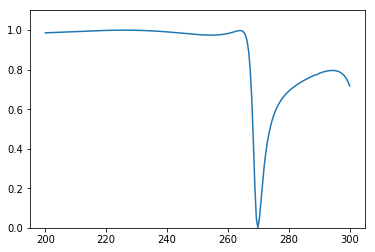

Test 51
True shape: [0.1        0.09876883 0.1        0.2        0.2        0.3       ]
Predicted shape: [[0.1210562  0.11220679 0.11011037 0.19372171 0.18446566 0.2772326 ]]

Predicted shape: [[0.13096434 0.11962706 0.13594148 0.19451115 0.15324797 0.24456736]]



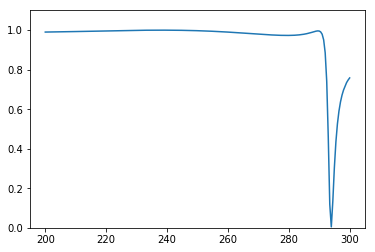

Test 52
True shape: [0.09876883 0.1        0.2        0.3        0.2        0.2       ]
Predicted shape: [[0.14766419 0.15603688 0.1935342  0.26863468 0.18604572 0.13069923]]

Predicted shape: [[0.10563806 0.10581577 0.18597516 0.29289174 0.19667345 0.22004841]]



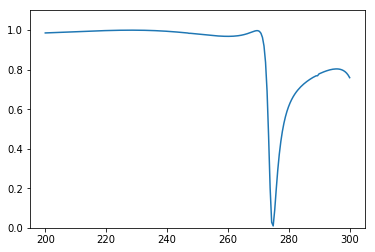

Test 53
True shape: [0.1        0.13169178 0.2        0.2        0.2        0.2       ]
Predicted shape: [[0.10567474 0.17174801 0.1853539  0.19973567 0.21190846 0.0927648 ]]

Predicted shape: [[0.08454508 0.14274713 0.20891961 0.19760343 0.20093521 0.16120353]]



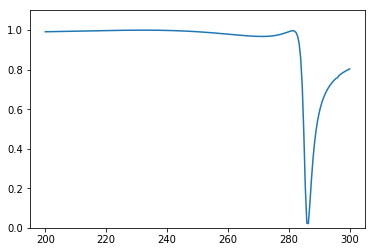

Test 54
True shape: [0.3 0.2 0.1 0.1 0.2 0.3]
Predicted shape: [[0.10689804 0.10282519 0.11595032 0.19449699 0.2594851  0.2360749 ]]

Predicted shape: [[0.19160062 0.15925369 0.10678536 0.1704717  0.24925177 0.24554648]]



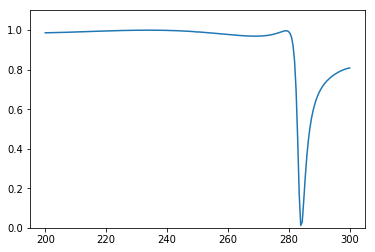

Test 55
True shape: [0.2        0.2        0.1        0.13169178 0.2        0.19753767]
Predicted shape: [[0.12652281 0.13565055 0.16970915 0.17271972 0.16281721 0.16482219]]

Predicted shape: [[0.16401964 0.14797363 0.15287575 0.15825766 0.17812556 0.21153505]]



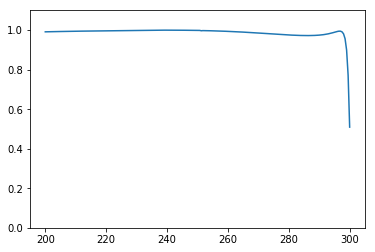

Test 56
True shape: [0.1        0.2        0.2        0.2        0.2        0.19753767]
Predicted shape: [[0.10266525 0.19482896 0.19723764 0.19845238 0.21154076 0.20693356]]

Predicted shape: [[0.09173143 0.19484308 0.1990676  0.21106207 0.18846703 0.21611632]]



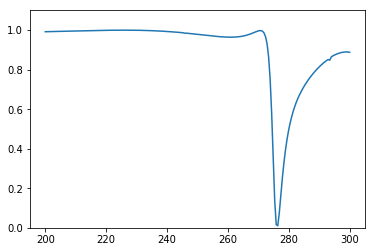

Test 57
True shape: [0.1        0.13169178 0.2        0.2        0.19753767 0.2       ]
Predicted shape: [[0.10672697 0.12922534 0.18801135 0.19497517 0.18954359 0.19771186]]

Predicted shape: [[0.09684557 0.14948368 0.20608202 0.1868757  0.19367002 0.20132664]]



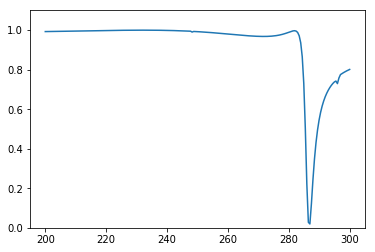

Test 58
True shape: [0.1        0.2        0.19753767 0.2        0.1        0.09876883]
Predicted shape: [[0.18489581 0.16152456 0.16396713 0.16443151 0.14225505 0.17840897]]

Predicted shape: [[0.19313943 0.17793873 0.17520422 0.15578637 0.136613   0.15171725]]



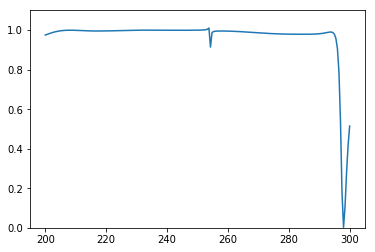

Test 59
True shape: [0.3        0.2370452  0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.10916865 0.11252585 0.1287151  0.19567949 0.30308333 0.19844201]]

Predicted shape: [[0.09895229 0.12254906 0.17224386 0.19527048 0.22078799 0.26730764]]



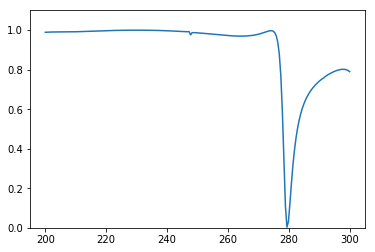

Test 60
True shape: [0.1        0.11723925 0.14600443 0.2        0.2        0.3       ]
Predicted shape: [[0.10108915 0.10963324 0.09930703 0.21589977 0.23912019 0.29615802]]

Predicted shape: [[0.10809144 0.11212447 0.12323916 0.20584935 0.21938412 0.29954574]]



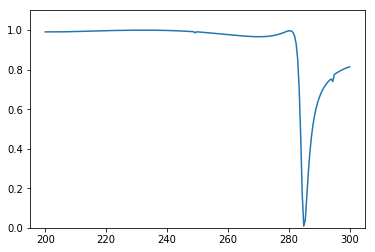

Test 61
True shape: [0.1        0.09876883 0.1        0.2        0.2370452  0.3       ]
Predicted shape: [[0.09524086 0.10007989 0.09392375 0.20907623 0.2315343  0.28788504]]

Predicted shape: [[0.11031479 0.10966554 0.10593066 0.18968612 0.2307761  0.3132217 ]]



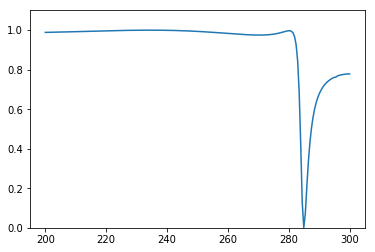

Test 62
True shape: [0.19753767 0.2        0.1        0.2        0.3        0.2       ]
Predicted shape: [[0.16659743 0.17751518 0.2018987  0.21191904 0.19941951 0.16924067]]

Predicted shape: [[0.20956764 0.18560806 0.1719577  0.18762785 0.20481448 0.21873856]]



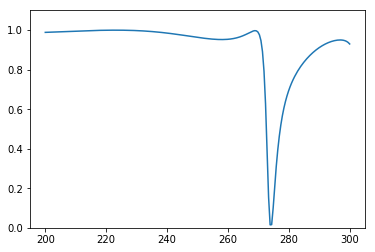

Test 63
True shape: [0.2 0.2 0.1 0.2 0.2 0.2]
Predicted shape: [[0.1459975  0.19006568 0.15896153 0.18255576 0.16917123 0.1717421 ]]

Predicted shape: [[0.22239232 0.17769802 0.12925068 0.1626704  0.1893823  0.19477788]]



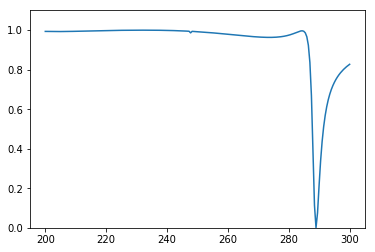

Test 64
True shape: [0.1 0.1 0.2 0.3 0.2 0.2]
Predicted shape: [[0.19009507 0.18337208 0.22379094 0.24401256 0.14408793 0.1342207 ]]

Predicted shape: [[0.10810658 0.07804301 0.1850968  0.3012126  0.19629535 0.21955901]]



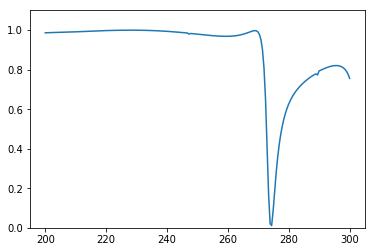

Test 65
True shape: [0.3        0.2370452  0.2        0.1        0.09876883 0.1       ]
Predicted shape: [[0.25493616 0.25204366 0.1978429  0.13087946 0.09284849 0.09005345]]

Predicted shape: [[0.25483516 0.24383736 0.19797623 0.12369627 0.09679914 0.10503593]]



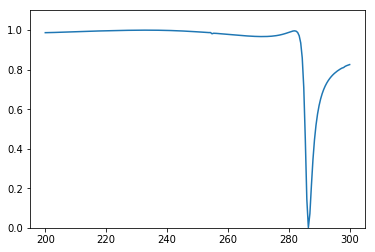

Test 66
True shape: [0.3        0.2        0.13169178 0.1        0.13169178 0.2       ]
Predicted shape: [[0.13498595 0.18229014 0.18031242 0.14358684 0.15077636 0.16634181]]

Predicted shape: [[0.17647079 0.17560986 0.15256292 0.11527264 0.1681332  0.20524138]]



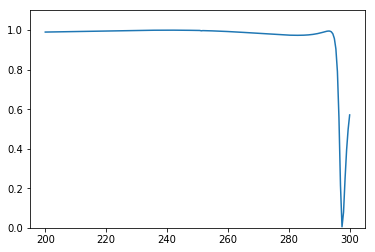

Test 67
True shape: [0.2        0.2        0.19507534 0.19507534 0.2        0.1       ]
Predicted shape: [[0.20435852 0.19470295 0.18989584 0.19316158 0.20425187 0.09720202]]

Predicted shape: [[0.19967371 0.21372056 0.18638206 0.20256457 0.19434795 0.10718373]]



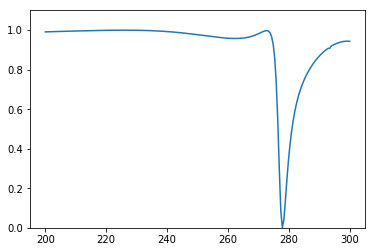

Test 68
True shape: [0.1        0.13169178 0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.20949572 0.16713059 0.15804541 0.14313382 0.1584648  0.17962751]]

Predicted shape: [[0.20015696 0.18218341 0.1794135  0.15764731 0.13248016 0.14825837]]



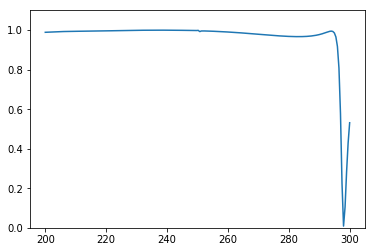

Test 69
True shape: [0.3        0.2        0.13169178 0.1        0.2        0.19753767]
Predicted shape: [[0.32856423 0.1837017  0.1774863  0.11523104 0.17200659 0.11349799]]

Predicted shape: [[0.31352812 0.20038357 0.1501821  0.11682752 0.20571055 0.21103714]]



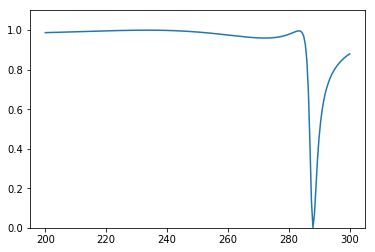

Test 70
True shape: [0.1 0.1 0.1 0.2 0.3 0.2]
Predicted shape: [[0.10429427 0.10124046 0.10411647 0.20161217 0.29883417 0.19080277]]

Predicted shape: [[0.15126342 0.12625378 0.11554176 0.18004864 0.27104285 0.21606238]]



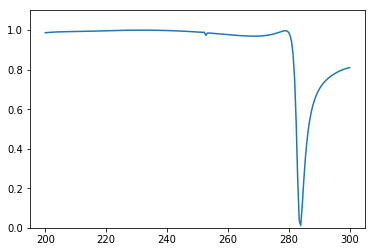

Test 71
True shape: [0.19753767 0.2        0.2        0.2        0.2        0.2       ]
Predicted shape: [[0.19899392 0.19755203 0.19892374 0.20277894 0.19801061 0.19432184]]

Predicted shape: [[0.19683269 0.2004923  0.19210055 0.19410732 0.20007287 0.20481364]]



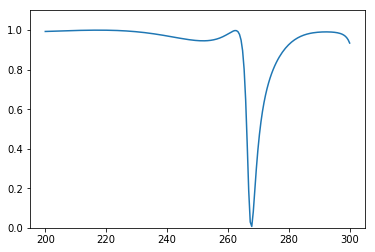

Test 72
True shape: [0.19753767 0.2        0.1        0.2        0.19753767 0.2       ]
Predicted shape: [[0.19164556 0.17344147 0.12497094 0.16598204 0.18078215 0.19520493]]

Predicted shape: [[0.22644824 0.18974084 0.13017467 0.1835174  0.17117342 0.20161511]]



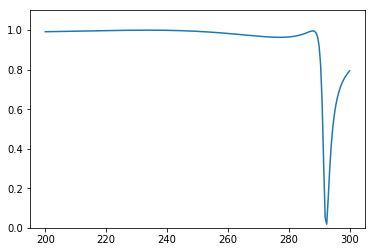

Test 73
True shape: [0.2 0.1 0.2 0.2 0.2 0.3]
Predicted shape: [[0.19224325 0.10688061 0.19088379 0.1911979  0.19035946 0.27475756]]

Predicted shape: [[0.20086306 0.14182991 0.18693659 0.20105538 0.2183504  0.2746337 ]]



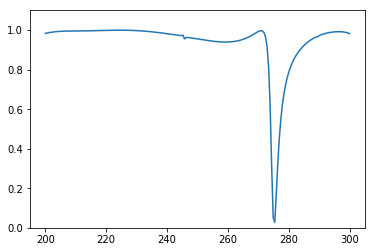

Test 74
True shape: [0.19753767 0.2        0.19753767 0.2        0.1        0.2       ]
Predicted shape: [[0.19162771 0.21006674 0.21213111 0.1935769  0.11342652 0.09357433]]

Predicted shape: [[0.18923926 0.20187253 0.19890836 0.18906903 0.12614661 0.1179305 ]]



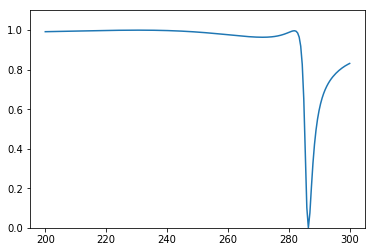

Test 75
True shape: [0.2        0.19753767 0.2        0.19507534 0.19507534 0.2       ]
Predicted shape: [[0.1958502  0.19963416 0.19722542 0.20372266 0.20141602 0.19139466]]

Predicted shape: [[0.20419377 0.20155361 0.19506186 0.19379282 0.19644521 0.1936373 ]]



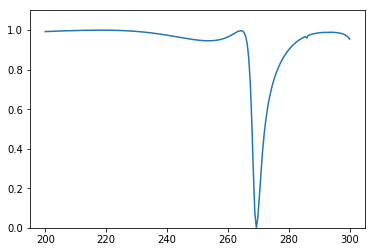

Test 76
True shape: [0.1        0.1        0.13169178 0.2        0.3        0.2       ]
Predicted shape: [[0.328835   0.21889898 0.11490121 0.13686278 0.18796688 0.24890688]]

Predicted shape: [[0.1537517  0.17267966 0.15841398 0.15391442 0.2006398  0.23369731]]



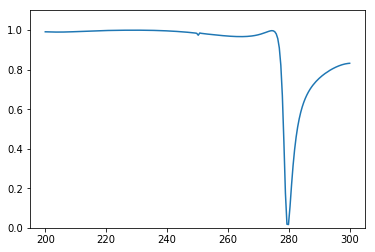

Test 77
True shape: [0.4        0.3        0.2370452  0.2        0.1        0.09876883]
Predicted shape: [[0.385057   0.28183818 0.23417878 0.19326675 0.10184503 0.09052547]]

Predicted shape: [[0.4062366  0.2890939  0.22685322 0.18445191 0.10041677 0.11102604]]



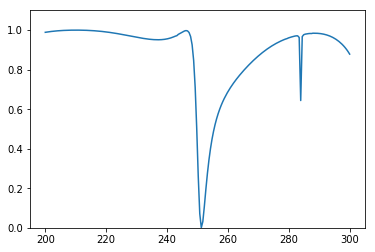

Test 78
True shape: [0.1        0.13169178 0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.10535803 0.16647992 0.22679222 0.20758554 0.20160407 0.30330727]]

Predicted shape: [[0.09379107 0.13665688 0.19546577 0.2052351  0.30848458 0.2092345 ]]



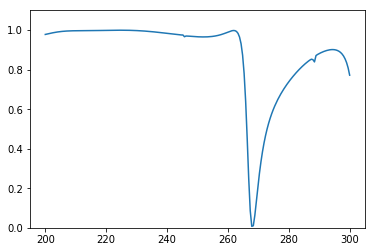

Test 79
True shape: [0.2        0.2        0.3        0.2        0.1        0.09876883]
Predicted shape: [[0.19106466 0.1683743  0.16130215 0.20227474 0.21848461 0.1959683 ]]

Predicted shape: [[0.2286512  0.19002286 0.2550574  0.20722222 0.11326058 0.14121868]]



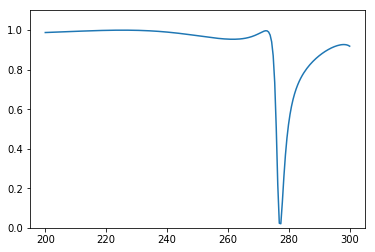

Test 80
True shape: [0.1618034  0.1638203  0.17013016 0.1815962  0.2        0.1       ]
Predicted shape: [[0.14569592 0.14316893 0.12328109 0.15540487 0.18140619 0.27269283]]

Predicted shape: [[0.15305078 0.12273091 0.15465549 0.17446673 0.1836404  0.22621505]]



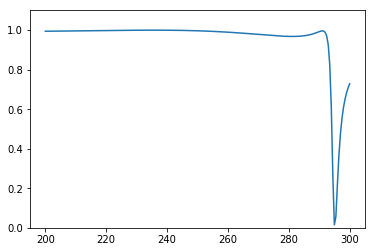

Test 81
True shape: [0.1        0.13169178 0.2        0.19507534 0.19507534 0.2       ]
Predicted shape: [[0.2736331  0.21554068 0.17647785 0.1313053  0.1438772  0.18814878]]

Predicted shape: [[0.23384497 0.18075898 0.16318515 0.14839411 0.17052461 0.1926567 ]]



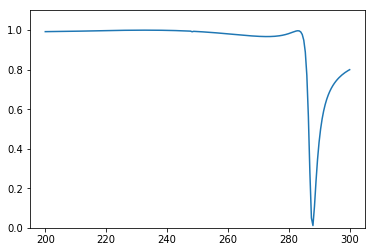

Test 82
True shape: [0.2 0.2 0.2 0.2 0.1 0.1]
Predicted shape: [[0.20470428 0.18874758 0.19945237 0.16475111 0.12216631 0.11949413]]

Predicted shape: [[0.20215029 0.18825519 0.20142424 0.19087681 0.09285492 0.10303517]]



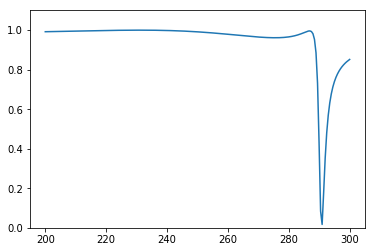

Test 83
True shape: [0.2 0.1 0.2 0.1 0.2 0.3]
Predicted shape: [[0.155462   0.12748277 0.10308257 0.18700895 0.18878181 0.23370919]]

Predicted shape: [[0.22775435 0.18209979 0.15754473 0.13137189 0.16129676 0.22540128]]



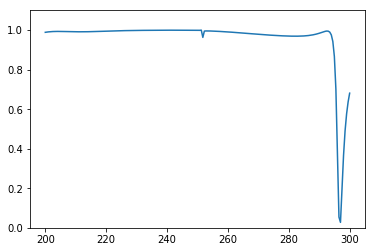

Test 84
True shape: [0.19753767 0.2        0.1        0.1        0.2        0.3       ]
Predicted shape: [[0.22004467 0.16156033 0.14862517 0.1217117  0.18127674 0.20547836]]

Predicted shape: [[0.203107   0.16997543 0.14402857 0.12227303 0.18751752 0.2597697 ]]



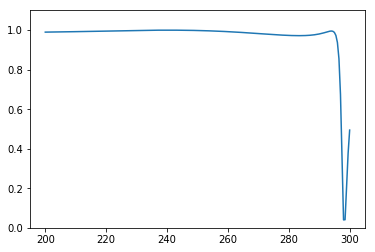

Test 85
True shape: [0.2        0.13169178 0.1        0.2        0.2        0.19753767]
Predicted shape: [[0.16917253 0.144362   0.10046265 0.14820188 0.20171428 0.26454425]]

Predicted shape: [[0.208859   0.18001232 0.15393868 0.12299159 0.16916035 0.24213788]]



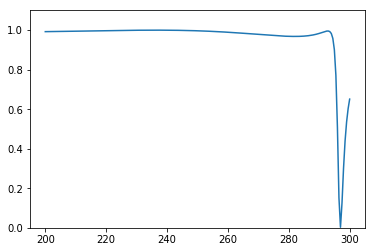

Test 86
True shape: [0.1        0.1        0.13169178 0.2        0.3        0.3       ]
Predicted shape: [[0.12158173 0.10690945 0.09049192 0.23719987 0.3346239  0.21778587]]

Predicted shape: [[0.11003295 0.10610121 0.1419437  0.19410637 0.2888319  0.31721094]]



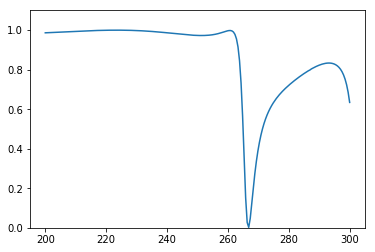

Test 87
True shape: [0.19753767 0.2        0.1        0.2        0.2        0.3       ]
Predicted shape: [[0.18704796 0.18650392 0.19450244 0.12335157 0.19597484 0.26952735]]

Predicted shape: [[0.25548333 0.19225302 0.16729936 0.14590958 0.18830933 0.23525669]]



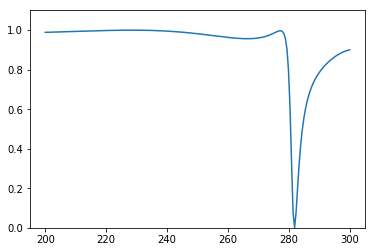

Test 88
True shape: [0.1        0.13169178 0.2        0.2        0.2        0.3       ]
Predicted shape: [[0.09914362 0.14691156 0.20632863 0.19559821 0.19508196 0.29039833]]

Predicted shape: [[0.08386743 0.1397543  0.18534777 0.20574969 0.20145416 0.30035132]]



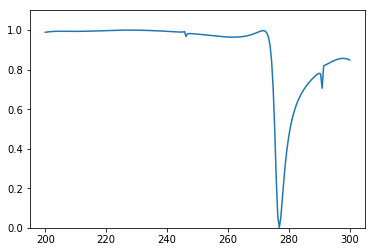

Test 89
True shape: [0.3        0.2        0.15329674 0.12680754 0.11044282 0.1       ]
Predicted shape: [[0.16612461 0.2095671  0.1767453  0.14361277 0.14238767 0.15448815]]

Predicted shape: [[0.20173326 0.15029237 0.15631053 0.14927584 0.15475616 0.1782703 ]]



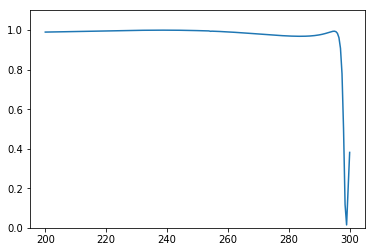

Test 90
True shape: [0.2        0.2        0.2        0.2        0.1        0.09876883]
Predicted shape: [[0.20943499 0.18918037 0.19774008 0.16501558 0.119908   0.12099472]]

Predicted shape: [[0.20334741 0.18972257 0.20162493 0.18885264 0.09227635 0.10264248]]



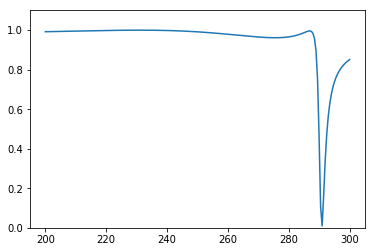

Test 91
True shape: [0.2 0.3 0.2 0.1 0.1 0.2]
Predicted shape: [[0.0977819  0.10195032 0.17194271 0.19181487 0.22190797 0.27997798]]

Predicted shape: [[0.19900054 0.28442088 0.22037297 0.09183571 0.11784729 0.19537738]]



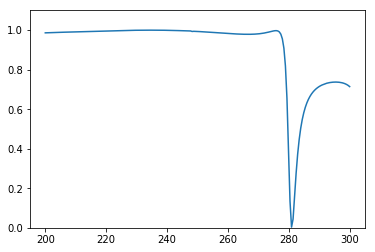

Test 92
True shape: [0.28531695 0.28887347 0.3        0.2        0.19753767 0.2       ]
Predicted shape: [[0.24458748 0.21817967 0.25158775 0.24894139 0.13573222 0.10020953]]

Predicted shape: [[0.29808384 0.28148982 0.28673398 0.20746791 0.21011606 0.21226351]]



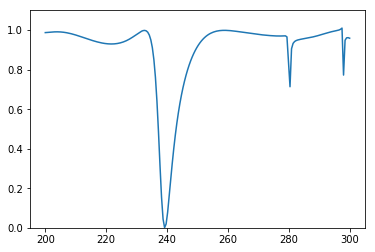

In [9]:
predicted = []
DFNN_all = load_model('DFNN_all')
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    print('Predicted shape: ' + str(DFNN_all.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))
    

In [21]:
model.save('DFNN_O')

In [20]:
np.savetxt('prediction_dfnn.txt', predicted)

Train on 119 samples, validate on 30 samples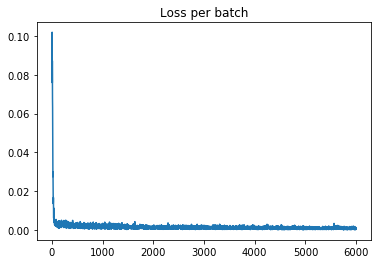